In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from sklearn import metrics

In [2]:
pd.set_option('future.no_silent_downcasting', True)
PALETTE = sns.color_palette('flare_r', as_cmap=True)
alt.renderers.enable('browser')

RendererRegistry.enable('browser')

# Section I: Notebook set-up

In [3]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [4]:
GENERAL_RATIO = set_size(width='thesis', fraction=3.0)
SPECIAL_RATIO = set_size(width='thesis', fraction=5.0)

Y_LABEL_FONT = 13
X_LABEL_FONT = 13
TITLE_FONT = 15
ANOT_FONT = 10

# Section II: Clusering Evaluation

In [5]:
def label_clusters(row):
    unique_values = row.unique()
    letter_digit = {}
    for number, value in enumerate(unique_values):
        letter_digit[value] = number
    row = row.replace(letter_digit)
    return row

def calculate_metric(row, metric, true_labels):
    return(metric(row, true_labels))

# Standard: "DATASET_{NUMBER OF CLIENTS}_{SPLIT TYPE}"
# 'NB' - Nonoverlaping Balanced
# 'NI' - Nonoverlaping Imbalanced
# 'OB' - Overlaping Balanced
# 'OI' - Overlaping Imbalanced
datasets = ['MNIST', 'FMNIST', 'CIFAR10', 'PATHMNIST']
no_of_clients = ['15', '30']
split_types = ['nonoverlaping', 'overlaping']
split_balance = ['balanced', 'imbalanced']
scenarios = [
    f"{dataset}_{clients}_{split}_{balance}"
    for dataset in datasets
    for clients in no_of_clients
    for split in split_types
    for balance in split_balance
]
algos = ['BNC', 'SCL', 'BCL', 'EFL-KMEANS', 'EFL-AFFINITY', 'EFL-MEANSHIFT', 'EFL-HDBSCAN']

clustering_info_stack = ['RAND', 'AMI', 'COM']
clustering_avg_per_scenario = {
    scenario: pd.DataFrame(index = algos, columns=clustering_info_stack)
    # RAND: Rand Score
    # AMI: Adjusted Mutual Information Score
    # COM: Cluster Completeness
    for scenario in scenarios
}

TRUE_LABELS = {
    'nonoverlaping_balanced_15': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'nonoverlaping_imbalanced_15': [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'overlaping_balanced_15': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'overlaping_imbalanced_15': [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'nonoverlaping_balanced_30': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    'nonoverlaping_imbalanced_30': [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    'overlaping_balanced_30': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
    'overlaping_imbalanced_30': [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3]
}

In [6]:
for dataset in datasets:
    for no_clients in no_of_clients:
        for split in split_types:
            for balance in split_balance:
            
                # I. Clustering Correctness
                ROOT = os.path.join(os.getcwd(), f'experiments/{dataset}/{split}/{balance}/{no_clients}')
                BASELINE_ATT = pd.read_csv(os.path.join(ROOT, f'baseline_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                if dataset == 'MNIST' or dataset == 'FMNIST':
                    SATTLER_ATT = pd.read_csv(os.path.join(ROOT, f'sattler_{dataset}_{split}_{balance}_{no_clients}_old/results/cluster_id_mapping.csv'))
                else:
                    SATTLER_ATT = pd.read_csv(os.path.join(ROOT, f'sattler_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                BRIGGS_ATT = pd.read_csv(os.path.join(ROOT, f'briggs_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                KMEANS_ATT = pd.read_csv(os.path.join(ROOT, f'kmeans_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                AFFINITY_ATT = pd.read_csv(os.path.join(ROOT, f'affinity_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                MEAN_SHIFT_ATT = pd.read_csv(os.path.join(ROOT, f'meanshift_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                HDBSCAN_ATT = pd.read_csv(os.path.join(ROOT, f'HDBSCAN_{dataset}_{split}_{balance}_{no_clients}/results/cluster_id_mapping.csv'))
                
                true_labels = TRUE_LABELS[f'{split}_{balance}_{no_clients}']
                
                BASELINE_ATT_GROUPED = BASELINE_ATT.apply(label_clusters, axis=1)
                SATTLER_ATT_GROUPED = SATTLER_ATT.apply(label_clusters, axis=1)
                BRIGGS_ATT_GROUPED = BRIGGS_ATT.apply(label_clusters, axis=1)
                KMEANS_ATT_GROUPED = KMEANS_ATT.apply(label_clusters, axis=1)
                AFFINITY_ATT_GROUPED = AFFINITY_ATT.apply(label_clusters, axis=1)
                MEAN_SHIFT_ATT_GROUPED = MEAN_SHIFT_ATT.apply(label_clusters, axis=1)
                HDBSCAN_ATT_GROUPED = HDBSCAN_ATT.apply(label_clusters, axis=1)
                
                RAND_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'EFL-KMEANS', 'EFL-AFFINITY', 'EFL-MEANSHIFT', 'EFL-HDBSCAN'], index=range(50))
                RAND_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['EFL-KMEANS'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['EFL-AFFINITY'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['EFL-MEANSHIFT'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                RAND_SCORES['EFL-HDBSCAN'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                
                MIS_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'EFL-KMEANS', 'EFL-AFFINITY', 'EFL-MEANSHIFT', 'EFL-HDBSCAN'], index=range(50))
                MIS_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['EFL-KMEANS'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['EFL-AFFINITY'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['EFL-MEANSHIFT'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_mutual_info_score, true_labels = true_labels, axis=1)
                MIS_SCORES['EFL-HDBSCAN'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = true_labels, axis=1)
                
                COM_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'EFL-KMEANS', 'EFL-AFFINITY', 'EFL-MEANSHIFT', 'EFL-HDBSCAN'], index=range(50))
                COM_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['EFL-KMEANS'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['EFL-AFFINITY'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['EFL-MEANSHIFT'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                COM_SCORES['EFL-HDBSCAN'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.completeness_score, true_labels = true_labels, axis=1)
                
                key = f'{dataset}_{no_clients}_{split}_{balance}'
                clustering_avg_per_scenario[key]['RAND'] = RAND_SCORES.mean()
                clustering_avg_per_scenario[key]['AMI'] = MIS_SCORES.mean()
                clustering_avg_per_scenario[key]['COM'] = COM_SCORES.mean()
                if not os.path.exists(os.path.join(os.getcwd(), 'tables', 'clustering_performance')):
                    os.makedirs(os.path.join(os.getcwd(), 'tables', 'clustering_performance'))
                
                with open(os.path.join(os.getcwd(), 'tables', 'clustering_performance', f"{key}.tex"), 'w+') as file:
                    file.write(clustering_avg_per_scenario[key].to_latex(float_format="%.2f"))

# Section III: General Performance Analysis

In [7]:
# Standard: "DATASET_{NUMBER OF CLIENTS}_{SPLIT TYPE}"
# 'NB' - Nonoverlaping Balanced
# 'NI' - Nonoverlaping Imbalanced
# 'OB' - Overlaping Balanced
# 'OI' -ssa Overlaping Imbalanced
datasets = ['MNIST', 'FMNIST', 'CIFAR10', 'PATHMNIST']
no_of_clients = ['15', '30']
split_types = ['nonoverlaping', 'overlaping']
split_balance = ['balanced', 'imbalanced']
scenarios = [
    f"{dataset}_{clients}_{split}_{balance}"
    for dataset in datasets
    for clients in no_of_clients
    for split in split_types
    for balance in split_balance
]
algos = ['BNC', 'SCL', 'BCL', 'OCFL-KM', 'OCFL-AFF', 'OCFL-MS', 'OCFL-HDB']

learning_info_stack = ['PA', 'PF1', 'GA', 'GF1', 'DIST']
learning_avg_per_scenario = {
    scenario: pd.DataFrame(index = algos, columns=learning_info_stack)
    # PA: Personalization Accuracy
    # PF1: Personalization F1score
    # GA: Generalization Accuracy
    # GF1: Generalization F1Score
    # DIST: Adjusted Distance (1 - |PA - GA|)
    for scenario in scenarios
}

full_info_stack = ['mean', 'std', 'min', 'max', '25%', '50%', '75%']
full_acc_info_per_scenario = {
    scenario: pd.DataFrame(index = algos, columns=full_info_stack)
    for scenario in scenarios
}

full_f1_info_per_scenario = {
    scenario: pd.DataFrame(index = algos, columns=full_info_stack)
    for scenario in scenarios
}

In [8]:
for dataset in datasets:
    for no_clients in no_of_clients:
        for split in split_types:
            for balance in split_balance:
                
                # Loading and calculating performance scores
                ROOT = os.path.join(os.getcwd(), f'experiments/{dataset}/{split}/{balance}/{no_clients}')
                BASELINE = os.path.join(ROOT, f'baseline_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv')
                if dataset == 'MNIST' or dataset == 'FMNIST':
                    SATTLER = os.path.join(ROOT, f'sattler_{dataset}_{split}_{balance}_{no_clients}_old/results/after_update_metrics.csv')
                else:
                    SATTLER = os.path.join(ROOT, f'sattler_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv')
                BRIGGS = os.path.join(ROOT, f'briggs_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv')
                KMEANS = os.path.join(ROOT, f'kmeans_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv')
                AFFINITY = os.path.join(ROOT, f'affinity_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv')
                MEAN_SHIFT = os.path.join(ROOT, f'meanshift_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv')
                HDBSCAN = os.path.join(ROOT, f'HDBSCAN_{dataset}_{split}_{balance}_{no_clients}/results/after_update_metrics.csv')
                baseline_global_model_on_nodes = pd.read_csv(BASELINE)
                sattler_global_model_on_nodes = pd.read_csv(SATTLER)
                briggs_global_model_on_nodes = pd.read_csv(BRIGGS)
                kmeans_global_model_on_nodes = pd.read_csv(KMEANS)
                affinity_global_model_on_nodes = pd.read_csv(AFFINITY)
                meanshift_global_model_on_nodes = pd.read_csv(MEAN_SHIFT)
                hdbscan_global_model_on_nodes = pd.read_csv(HDBSCAN)

                key = f'{dataset}_{no_clients}_{split}_{balance}'
                learning_avg_per_scenario[key].loc['BNC', 'PA'] = baseline_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['SCL', 'PA'] = sattler_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['BCL', 'PA'] = briggs_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-KM', 'PA'] = kmeans_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-AFF', 'PA'] = affinity_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-MS', 'PA'] = meanshift_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-HDB', 'PA'] = hdbscan_global_model_on_nodes['accuracy'].mean()

                learning_avg_per_scenario[key].loc['BNC', 'PF1'] = baseline_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['SCL', 'PF1']  = sattler_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['BCL', 'PF1'] = briggs_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-KM', 'PF1']  = kmeans_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-AFF', 'PF1'] = affinity_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-MS', 'PF1'] = meanshift_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-HDB', 'PF1'] = hdbscan_global_model_on_nodes['f1score'].mean()
                
                # Personalizaiton scores
                BASELINE = os.path.join(ROOT, f'baseline_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv')
                SATTLER = os.path.join(ROOT, f'sattler_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv')
                BRIGGS = os.path.join(ROOT, f'briggs_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv')
                KMEANS = os.path.join(ROOT, f'kmeans_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv')
                AFFINITY = os.path.join(ROOT, f'affinity_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv')
                MEAN_SHIFT = os.path.join(ROOT, f'meanshift_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv')
                HDBSCAN = os.path.join(ROOT, f'HDBSCAN_{dataset}_{split}_{balance}_{no_clients}/results/after_update_generalizability.csv')
                gen_baseline_global_model_on_nodes = pd.read_csv(BASELINE)
                gen_sattler_global_model_on_nodes = pd.read_csv(SATTLER)
                gen_briggs_global_model_on_nodes = pd.read_csv(BRIGGS)
                gen_kmeans_global_model_on_nodes = pd.read_csv(KMEANS)
                gen_affinity_global_model_on_nodes = pd.read_csv(AFFINITY)
                gen_meanshift_global_model_on_nodes = pd.read_csv(MEAN_SHIFT)
                gen_hdbscan_global_model_on_nodes = pd.read_csv(HDBSCAN)

                learning_avg_per_scenario[key].loc['BNC', 'GA'] = gen_baseline_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['SCL', 'GA'] = gen_sattler_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['BCL', 'GA']= gen_briggs_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-KM', 'GA'] = gen_kmeans_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-AFF', 'GA'] = gen_affinity_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-MS', 'GA'] = gen_meanshift_global_model_on_nodes['accuracy'].mean()
                learning_avg_per_scenario[key].loc['OCFL-HDB', 'GA']  = gen_hdbscan_global_model_on_nodes['accuracy'].mean()

                learning_avg_per_scenario[key].loc['BNC', 'GF1'] = gen_baseline_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['SCL', 'GF1'] = gen_sattler_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['BCL', 'GF1'] = gen_briggs_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-KM', 'GF1'] = gen_kmeans_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-AFF', 'GF1'] = gen_affinity_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-MS', 'GF1'] = gen_meanshift_global_model_on_nodes['f1score'].mean()
                learning_avg_per_scenario[key].loc['OCFL-HDB', 'GF1'] = gen_hdbscan_global_model_on_nodes['f1score'].mean()

                # Calculating delta scores
                learning_avg_per_scenario[key].loc['BNC', 'DIST'] = abs(baseline_global_model_on_nodes['accuracy'] - gen_baseline_global_model_on_nodes['accuracy']).mean()
                learning_avg_per_scenario[key].loc['SCL', 'DIST'] = abs(sattler_global_model_on_nodes['accuracy'] - gen_sattler_global_model_on_nodes['accuracy']).mean()
                learning_avg_per_scenario[key].loc['BCL', 'DIST'] = abs(briggs_global_model_on_nodes['accuracy'] - gen_briggs_global_model_on_nodes['accuracy']).mean()
                learning_avg_per_scenario[key].loc['OCFL-KM', 'DIST'] = abs(kmeans_global_model_on_nodes['accuracy'] - gen_kmeans_global_model_on_nodes['accuracy']).mean()
                learning_avg_per_scenario[key].loc['OCFL-AFF', 'DIST'] = abs(affinity_global_model_on_nodes['accuracy'] - gen_affinity_global_model_on_nodes['accuracy']).mean()
                learning_avg_per_scenario[key].loc['OCFL-MS', 'DIST'] = abs(meanshift_global_model_on_nodes['accuracy'] - gen_meanshift_global_model_on_nodes['accuracy']).mean()
                learning_avg_per_scenario[key].loc['OCFL-HDB', 'DIST']  = abs(hdbscan_global_model_on_nodes['accuracy'] - gen_hdbscan_global_model_on_nodes['accuracy']).mean()  

In [9]:
dfl2 = pd.DataFrame()

for key, df in learning_avg_per_scenario.items():
    df[['PA', 'PF1', 'GA', 'GF1', 'DIST']] = df[['PA', 'PF1', 'GA', 'GF1', 'DIST']].astype(float)
    df['scenario'] = key
    df['dataset'] = df['scenario'].apply(lambda x: ' '.join(x.split('_')[0:2]))
    df['splitting'] = df['scenario'].apply(lambda x: ' '.join(x.split('_')[2:4]).title())
    dfl2 = pd.concat([dfl2, df.reset_index()], axis=0)
    
dfl2

,index,PA,PF1,GA,GF1,DIST,scenario,dataset,splitting
0,BNC,0.844524,0.302475,0.391164,0.286148,0.456980,MNIST_15_nonoverlaping_balanced,MNIST 15,Nonoverlaping Balanced
1,SCL,0.891556,0.682639,0.391456,0.286129,0.505129,MNIST_15_nonoverlaping_balanced,MNIST 15,Nonoverlaping Balanced
2,BCL,0.842217,0.302296,0.401181,0.296725,0.447139,MNIST_15_nonoverlaping_balanced,MNIST 15,Nonoverlaping Balanced
3,OCFL-KM,0.962917,0.955202,0.323684,0.177630,0.641931,MNIST_15_nonoverlaping_balanced,MNIST 15,Nonoverlaping Balanced
4,OCFL-AFF,0.845538,0.470705,0.382009,0.263388,0.479789,MNIST_15_nonoverlaping_balanced,MNIST 15,Nonoverlaping Balanced
...,...,...,...,...,...,...,...,...,...
2,BCL,0.566365,0.314358,0.239970,0.143987,0.358776,PATHMNIST_30_overlaping_imbalanced,PATHMNIST 30,Overlaping Imbalanced
3,OCFL-KM,0.673704,0.368848,0.256421,0.144667,0.417418,PATHMNIST_30_overlaping_imbalanced,PATHMNIST 30,Overlaping Imbalanced
4,OCFL-AFF,0.510576,0.268686,0.258254,0.133731,0.287681,PATHMNIST_30_overlaping_imbalanced,PATHMNIST 30,Overlaping Imbalanced
5,OCFL-MS,0.633666,0.345999,0.273802,0.141797,0.376204,PATHMNIST_30_overlaping_imbalanced,PATHMNIST 30,Overlaping Imbalanced


In [17]:
base = alt.Chart(dfl2).encode(
    alt.X('index:N', title=None),
)

acc = base.mark_line().encode(
    alt.Y('PF1:Q', title='F1', axis=alt.Axis(tickCount = 5, tickRound=False)),
    alt.Y2('GF1:Q'),
)

pa = base.mark_tick(size=10).encode(
    alt.Y('PF1:Q', title=None),
)

ga = base.mark_tick(size=10).encode(
    alt.Y('GF1:Q', title=None),
)

    
((acc + pa + ga).properties(height=100, width=200)
    .facet(
        column=alt.Column('splitting:N', title=None), 
        row=alt.Column('dataset:N', title=None))
 .interactive())

alt.FacetChart(...)

In [16]:
# select only those rows where the attribute "dataset" is equal to "MNIST 15" or to "MNIST 30"
base = alt.Chart(dfl2[dfl2['dataset'].isin(['MNIST 15', 'MNIST 30'])]).encode(
    alt.X('index:N', title=None),
)

acc = base.mark_line().encode(
    alt.Y('PF1:Q', title='F1', axis=alt.Axis(tickCount = 5, tickRound=False)),
    alt.Y2('GF1:Q'),
)

pa = base.mark_tick(size=10).encode(
    alt.Y('PF1:Q', title=None),
)

ga = base.mark_tick(size=10).encode(
    alt.Y('GF1:Q', title=None),
)

    
((acc + pa + ga).properties(height=200, width=400)
    .facet(
        column=alt.Column('splitting:N', title=None), 
        row=alt.Column('dataset:N', title=None))
 .interactive())

alt.FacetChart(...)

# Section III: Examples of Clustering Performance on Individual Runs
Scenario: (non)overlapping balanced
Datasets: MNIST, FMNIST, CIFAR10, PATHMNIST

## RAND SCORE

### MNIST

[None, None, None, None, None, None, None]

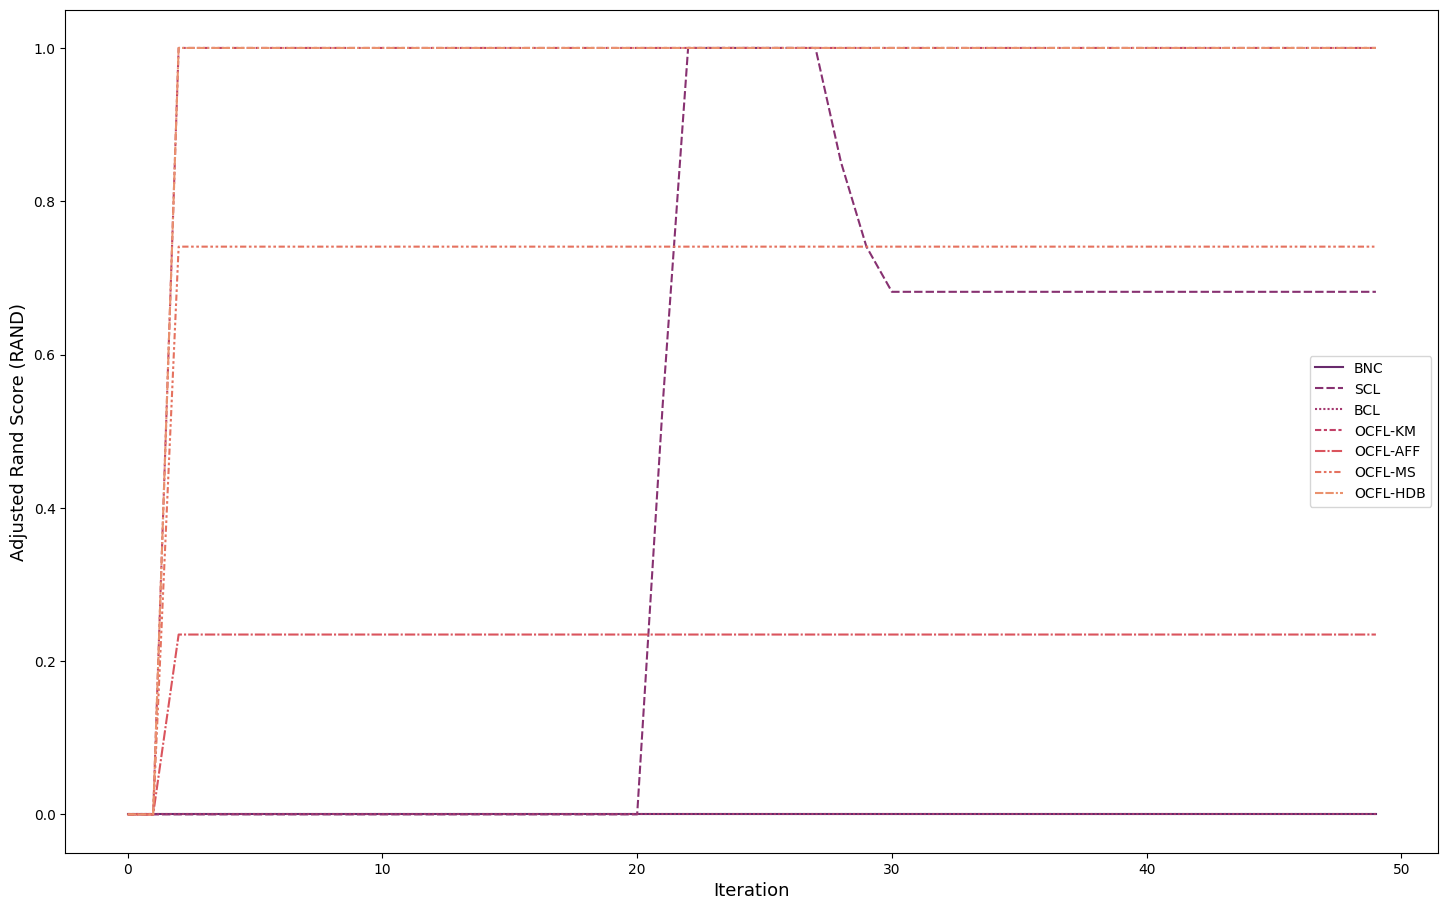

In [12]:
ROOT = os.path.join(os.getcwd(), 'experiments/MNIST/nonoverlaping/balanced/15')
BASELINE_ATT = pd.read_csv(os.path.join(ROOT, 'baseline_MNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
SATTLER_ATT = pd.read_csv(os.path.join(ROOT, 'sattler_MNIST_nonoverlaping_balanced_15_old/results/cluster_id_mapping.csv'))
BRIGGS_ATT = pd.read_csv(os.path.join(ROOT, 'briggs_MNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
KMEANS_ATT = pd.read_csv(os.path.join(ROOT, 'kmeans_MNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
AFFINITY_ATT = pd.read_csv(os.path.join(ROOT, 'affinity_MNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
MEAN_SHIFT_ATT = pd.read_csv(os.path.join(ROOT, 'meanshift_MNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
HDBSCAN_ATT = pd.read_csv(os.path.join(ROOT, 'HDBSCAN_MNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
 
TRUE_LABELS = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
BASELINE_ATT_GROUPED = BASELINE_ATT.apply(label_clusters, axis=1)
SATTLER_ATT_GROUPED = SATTLER_ATT.apply(label_clusters, axis=1)
BRIGGS_ATT_GROUPED = BRIGGS_ATT.apply(label_clusters, axis=1)
KMEANS_ATT_GROUPED = KMEANS_ATT.apply(label_clusters, axis=1)
AFFINITY_ATT_GROUPED = AFFINITY_ATT.apply(label_clusters, axis=1)
MEAN_SHIFT_ATT_GROUPED = MEAN_SHIFT_ATT.apply(label_clusters, axis=1)
HDBSCAN_ATT_GROUPED = HDBSCAN_ATT.apply(label_clusters, axis=1)
 
RAND_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'OCFL-KM', 'OCFL-AFF', 'OCFL-MS', 'OCFL-HDB'], index=range(50))
RAND_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-KM'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-AFF'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-MS'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-HDB'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
 
#RAND_SCORES.plot(figsize=(10, 7), title='Adjusted Rand Score')
fig, ax = plt.subplots(figsize=GENERAL_RATIO)
ax.set_ylabel("Adjusted Rand Score (RAND)", fontsize=Y_LABEL_FONT)
ax.set_xlabel("Iteration", fontsize=X_LABEL_FONT)
sns.lineplot(RAND_SCORES, ax=ax, palette='flare_r')
plt.setp(ax.get_legend().get_texts(), fontsize=ANOT_FONT)
#fig.legend(prop={'size': 15})
 

### FMNIST

[None, None, None, None, None, None, None]

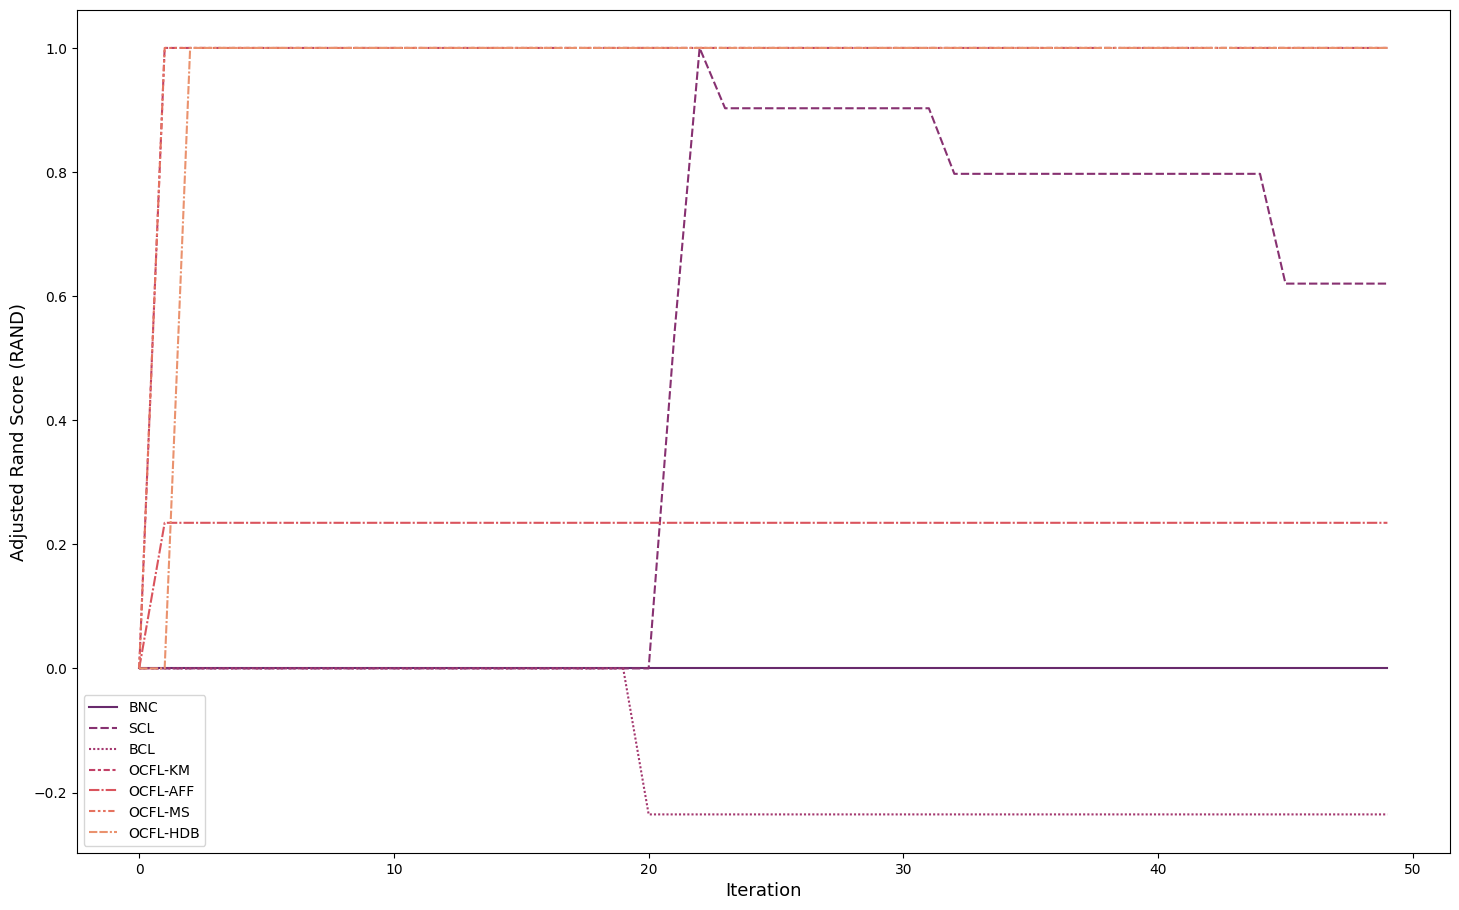

In [13]:
ROOT = os.path.join(os.getcwd(), 'experiments/FMNIST/nonoverlaping/balanced/15')
BASELINE_ATT = pd.read_csv(os.path.join(ROOT, 'baseline_FMNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
SATTLER_ATT = pd.read_csv(os.path.join(ROOT, 'sattler_FMNIST_nonoverlaping_balanced_15_old/results/cluster_id_mapping.csv'))
BRIGGS_ATT = pd.read_csv(os.path.join(ROOT, 'briggs_FMNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
KMEANS_ATT = pd.read_csv(os.path.join(ROOT, 'kmeans_FMNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
AFFINITY_ATT = pd.read_csv(os.path.join(ROOT, 'affinity_FMNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
MEAN_SHIFT_ATT = pd.read_csv(os.path.join(ROOT, 'meanshift_FMNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
HDBSCAN_ATT = pd.read_csv(os.path.join(ROOT, 'HDBSCAN_FMNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
 
TRUE_LABELS = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
BASELINE_ATT_GROUPED = BASELINE_ATT.apply(label_clusters, axis=1)
SATTLER_ATT_GROUPED = SATTLER_ATT.apply(label_clusters, axis=1)
BRIGGS_ATT_GROUPED = BRIGGS_ATT.apply(label_clusters, axis=1)
KMEANS_ATT_GROUPED = KMEANS_ATT.apply(label_clusters, axis=1)
AFFINITY_ATT_GROUPED = AFFINITY_ATT.apply(label_clusters, axis=1)
MEAN_SHIFT_ATT_GROUPED = MEAN_SHIFT_ATT.apply(label_clusters, axis=1)
HDBSCAN_ATT_GROUPED = HDBSCAN_ATT.apply(label_clusters, axis=1)
 
RAND_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'OCFL-KM', 'OCFL-AFF', 'OCFL-MS', 'OCFL-HDB'], index=range(50))
RAND_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-KM'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-AFF'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-MS'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-HDB'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
 
#RAND_SCORES.plot(figsize=(10, 7), title='Adjusted Rand Score')
fig, ax = plt.subplots(figsize=GENERAL_RATIO)
ax.set_ylabel("Adjusted Rand Score (RAND)", fontsize=Y_LABEL_FONT)
ax.set_xlabel("Iteration", fontsize=X_LABEL_FONT)
sns.lineplot(RAND_SCORES, ax=ax, palette='flare_r')
plt.setp(ax.get_legend().get_texts(), fontsize=ANOT_FONT)
#fig.legend(prop={'size': 15})
 

### CIFAR1O

[None, None, None, None, None, None, None]

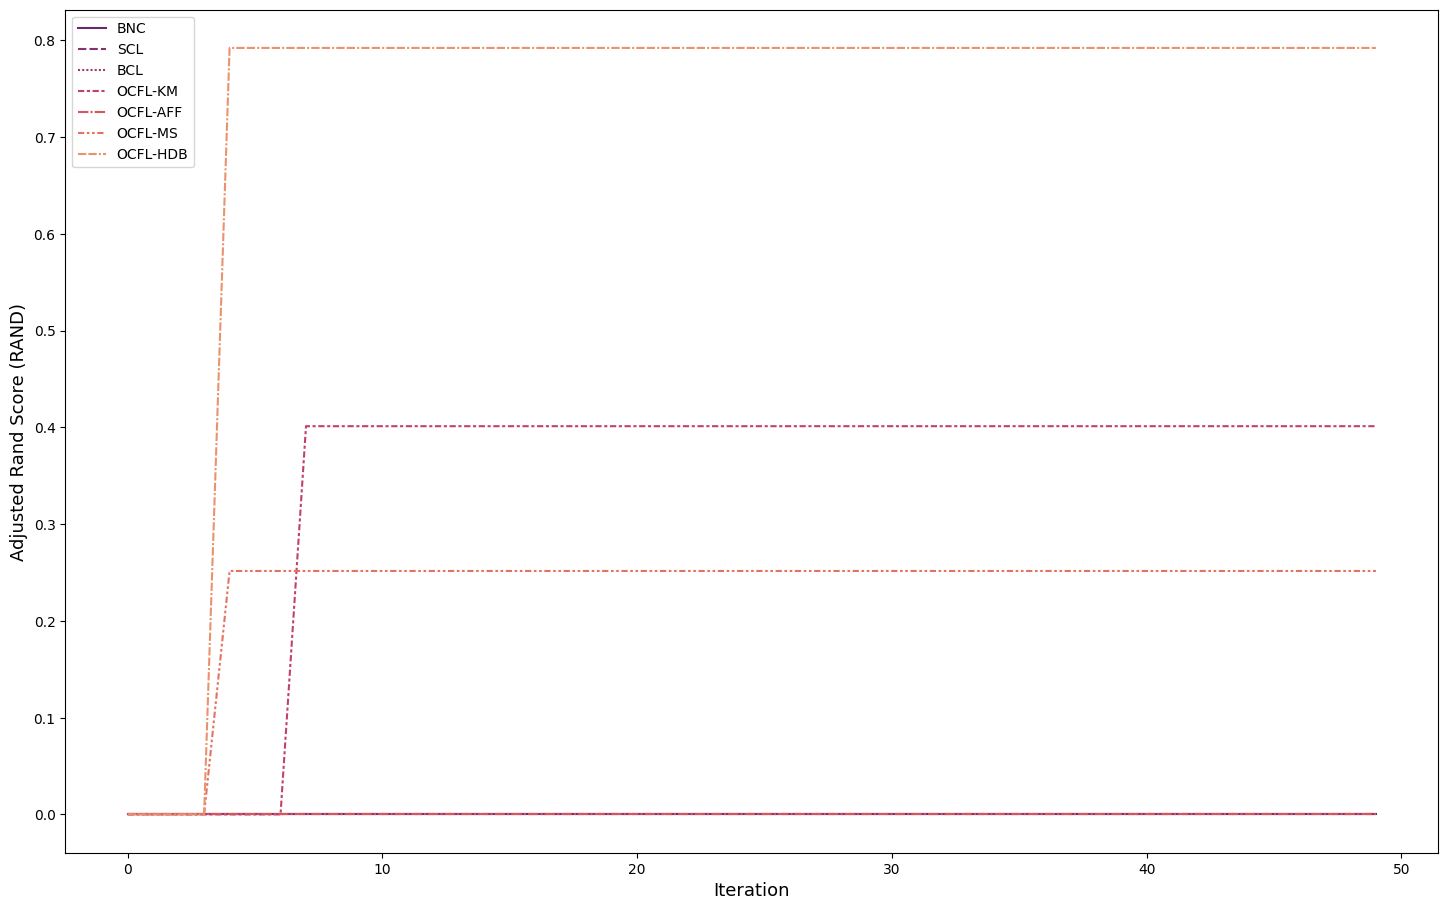

In [14]:
ROOT = os.path.join(os.getcwd(), 'experiments/CIFAR10/nonoverlaping/balanced/15')
BASELINE_ATT = pd.read_csv(os.path.join(ROOT, 'baseline_CIFAR10_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
SATTLER_ATT = pd.read_csv(os.path.join(ROOT, 'sattler_CIFAR10_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
BRIGGS_ATT = pd.read_csv(os.path.join(ROOT, 'briggs_CIFAR10_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
KMEANS_ATT = pd.read_csv(os.path.join(ROOT, 'kmeans_CIFAR10_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
AFFINITY_ATT = pd.read_csv(os.path.join(ROOT, 'affinity_CIFAR10_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
MEAN_SHIFT_ATT = pd.read_csv(os.path.join(ROOT, 'meanshift_CIFAR10_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
HDBSCAN_ATT = pd.read_csv(os.path.join(ROOT, 'HDBSCAN_CIFAR10_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
 
TRUE_LABELS = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
BASELINE_ATT_GROUPED = BASELINE_ATT.apply(label_clusters, axis=1)
SATTLER_ATT_GROUPED = SATTLER_ATT.apply(label_clusters, axis=1)
BRIGGS_ATT_GROUPED = BRIGGS_ATT.apply(label_clusters, axis=1)
KMEANS_ATT_GROUPED = KMEANS_ATT.apply(label_clusters, axis=1)
AFFINITY_ATT_GROUPED = AFFINITY_ATT.apply(label_clusters, axis=1)
MEAN_SHIFT_ATT_GROUPED = MEAN_SHIFT_ATT.apply(label_clusters, axis=1)
HDBSCAN_ATT_GROUPED = HDBSCAN_ATT.apply(label_clusters, axis=1)
 
RAND_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'OCFL-KM', 'OCFL-AFF', 'OCFL-MS', 'OCFL-HDB'], index=range(50))
RAND_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-KM'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-AFF'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-MS'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-HDB'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
 
#RAND_SCORES.plot(figsize=(10, 7), title='Adjusted Rand Score')
fig, ax = plt.subplots(figsize=GENERAL_RATIO)
ax.set_ylabel("Adjusted Rand Score (RAND)", fontsize=Y_LABEL_FONT)
ax.set_xlabel("Iteration", fontsize=X_LABEL_FONT)
sns.lineplot(RAND_SCORES, ax=ax, palette='flare_r')
plt.setp(ax.get_legend().get_texts(), fontsize=ANOT_FONT)
#fig.legend(prop={'size': 15})
 

### PATHMNIST

[None, None, None, None, None, None, None]

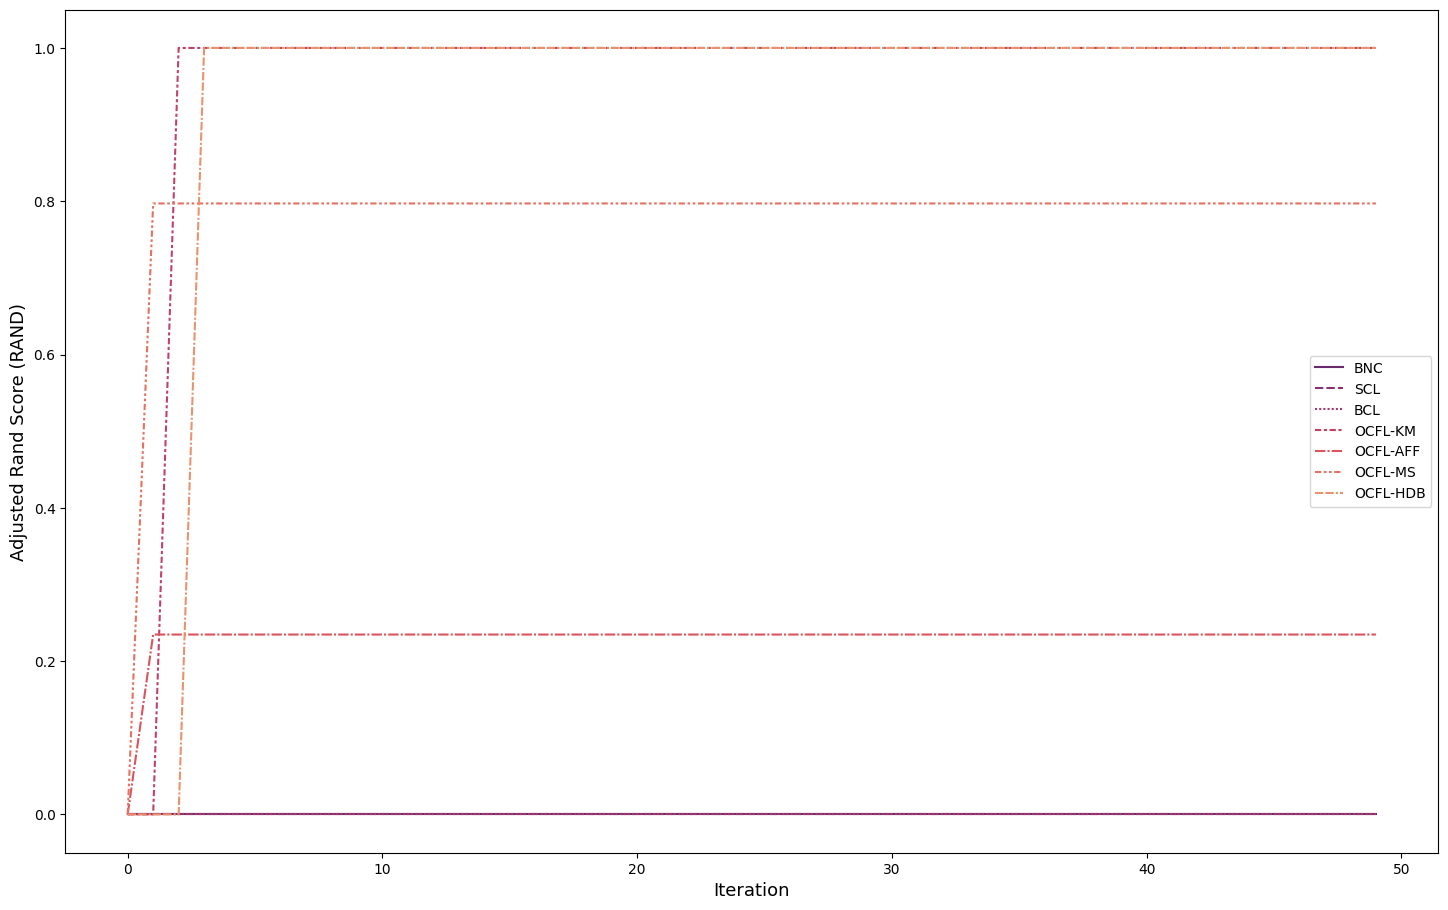

In [15]:
ROOT = os.path.join(os.getcwd(), 'experiments/PATHMNIST/nonoverlaping/balanced/15')
BASELINE_ATT = pd.read_csv(os.path.join(ROOT, 'baseline_PATHMNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
SATTLER_ATT = pd.read_csv(os.path.join(ROOT, 'sattler_PATHMNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
BRIGGS_ATT = pd.read_csv(os.path.join(ROOT, 'briggs_PATHMNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
KMEANS_ATT = pd.read_csv(os.path.join(ROOT, 'kmeans_PATHMNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
AFFINITY_ATT = pd.read_csv(os.path.join(ROOT, 'affinity_PATHMNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
MEAN_SHIFT_ATT = pd.read_csv(os.path.join(ROOT, 'meanshift_PATHMNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
HDBSCAN_ATT = pd.read_csv(os.path.join(ROOT, 'HDBSCAN_PATHMNIST_nonoverlaping_balanced_15/results/cluster_id_mapping.csv'))
 
TRUE_LABELS = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
BASELINE_ATT_GROUPED = BASELINE_ATT.apply(label_clusters, axis=1)
SATTLER_ATT_GROUPED = SATTLER_ATT.apply(label_clusters, axis=1)
BRIGGS_ATT_GROUPED = BRIGGS_ATT.apply(label_clusters, axis=1)
KMEANS_ATT_GROUPED = KMEANS_ATT.apply(label_clusters, axis=1)
AFFINITY_ATT_GROUPED = AFFINITY_ATT.apply(label_clusters, axis=1)
MEAN_SHIFT_ATT_GROUPED = MEAN_SHIFT_ATT.apply(label_clusters, axis=1)
HDBSCAN_ATT_GROUPED = HDBSCAN_ATT.apply(label_clusters, axis=1)
 
RAND_SCORES = pd.DataFrame(columns=['BNC', 'SCL', 'BCL', 'OCFL-KM', 'OCFL-AFF', 'OCFL-MS', 'OCFL-HDB'], index=range(50))
RAND_SCORES['BNC'] = BASELINE_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['SCL'] = SATTLER_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['BCL'] = BRIGGS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-KM'] = KMEANS_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-AFF'] = AFFINITY_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-MS'] = MEAN_SHIFT_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
RAND_SCORES['OCFL-HDB'] = HDBSCAN_ATT_GROUPED.apply(calculate_metric, metric = metrics.adjusted_rand_score, true_labels = TRUE_LABELS, axis=1)
 
#RAND_SCORES.plot(figsize=(10, 7), title='Adjusted Rand Score')
fig, ax = plt.subplots(figsize=GENERAL_RATIO)
ax.set_ylabel("Adjusted Rand Score (RAND)", fontsize=Y_LABEL_FONT)
ax.set_xlabel("Iteration", fontsize=X_LABEL_FONT)
sns.lineplot(RAND_SCORES, ax=ax, palette='flare_r')
plt.setp(ax.get_legend().get_texts(), fontsize=ANOT_FONT)
#fig.legend(prop={'size': 15})
 